# Main Libraries


In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython import display
import os
import json

# Step 2: Load Data With Extract SFTF Features

In [18]:
from utils import load_data

# Now, calling the load_data function
train_csv = "./Data/train.csv"  # Replace with the actual path to your CSV file
train_audio_dir = "./Data/train/"  # Replace with the directory containing your audio files

adapt_csv = "./Data/adapt.csv"  # Replace with the actual path to your CSV file
adapt_audio_dir = "./Data/Clean_Data/"  # Replace with the directory containing your audio files

train_dataset, validation_dataset, df_train, df_val = load_data(train_csv, train_audio_dir, adapt_csv, adapt_audio_dir)

# Calculate the size of the training dataset
train_size = sum(1 for _ in train_dataset.unbatch())

# Calculate the size of the validation dataset
validation_size = sum(1 for _ in validation_dataset.unbatch())

print(f"Size of the training set: {train_size}")
print(f"Size of the validation set: {validation_size}")

for spectrogram, label in train_dataset.take(1):  # Example of taking one batch
    print("Spectrogram shape:", spectrogram.shape)
    print("Label shape:", label.shape)

2024-06-29 20:27:39.744761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-29 20:27:39.829671: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-29 20:27:39.944434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Size of the training set: 24
Size of the validation set: 7
Spectrogram shape: (24, 883, 193)
Label shape: (24, 105)


# Sample From Training Dataset

2024-06-29 17:54:25.914106: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


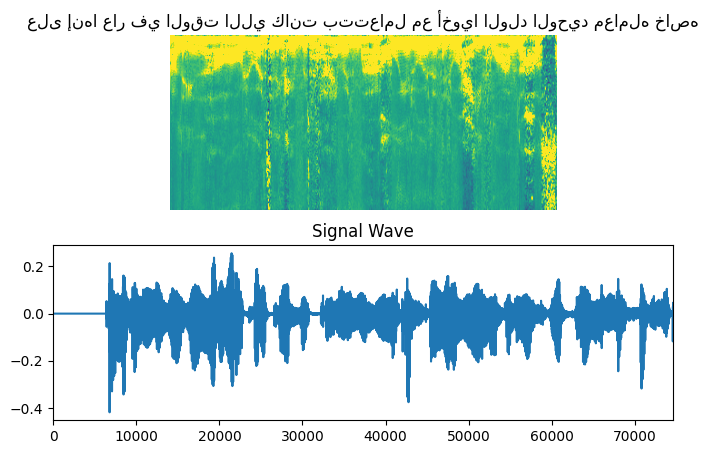

In [3]:
from features_extraction import num_to_char

fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")
    # Wav
    file = tf.io.read_file(df_train["audio_path"][0])
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()

# Load Model And Predict with it 

In [19]:
from keras.utils import register_keras_serializable

@register_keras_serializable()
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [20]:
# Load model configuration from JSON file
with open('./Models/model_config.json', 'r') as json_file:
    model_config = json.load(json_file)
 
model = keras.models.model_from_json(json.dumps(model_config))

In [21]:
# Load the model weights
model.load_weights('./Models/Model.h5')

# Compile the model with custom CTC loss function
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-6), loss=CTCLoss)

In [22]:
model.summary()

Model: "DeepSpeech_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, None, 193)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ expand_dim (Reshape)            │ (None, None, 193, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, None, 97, 32)   │        14,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1_bn (BatchNormalization)  │ (None, None, 97, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1_relu (ReLU)              │ (None, None, 97, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, None, 49, 32)   │       236,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2_bn (BatchNormalization)  │ (None, None, 49, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2_relu (ReLU)              │ (None, None, 49, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, None, 1568)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, None, 1024)     │     6,395,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, None, 1024)     │     4,724,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, None, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, None, 1024)     │     4,724,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, None, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, None, 1024)     │     4,724,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, None, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, None, 1024)     │     4,724,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, None, 1024)     │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1_relu (ReLU)             │ (None, None, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, None, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 39)       │        39,975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,635,655 (101.61 MB)

 Trainable params: 26,635,527 (101.61 MB)

 Non-trainable params: 128 (512.00 B)

# Test And Predict Transcriptions For The Test Data

#### After Making The Preprocessing On Whole Test Data From The Notebook That We Created In That Field We Get The Data As Direche Files Inside It.

In [23]:
from metrics import decode_batch_predictions
from features_extraction import preprocess_audio

# Define the directory containing your test audio files
test_audio_dir = './Data/test'
output_csv_path = './Data/predictions.csv'

# Get a list of test audio files
test_files = [os.path.join(test_audio_dir, f) for f in os.listdir(test_audio_dir) if f.endswith('.wav')]

# Initialize a list to store predictions
predictions = []

# Process each test file and make predictions
for audio_file in test_files:
    # Preprocess the audio file
    spectrogram = preprocess_audio(audio_file)
    spectrogram = tf.expand_dims(spectrogram, axis=0)  # Add batch dimension
    # Make prediction
    prediction = model.predict(spectrogram)
    # Decode prediction to text
    decoded_text = decode_batch_predictions(prediction)
    # Append the result with filename instead of full path
    predictions.append({'audio': os.path.splitext(os.path.basename(audio_file))[0], 'transcript': decoded_text[0]})

# Save predictions to CSV
pred_df = pd.DataFrame(predictions)
pred_df.to_csv(output_csv_path, index=False, encoding='utf-8')

print(f"Predictions saved to {output_csv_path}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 

**We Iterate On The Output CSV File to chick if empty put space**

In [24]:
# Initialize a list to store indices and rows with null values
null_rows = []

# Iterate over each row in the DataFrame
for index, row in pred_df.iterrows():
    if row.isnull().any():
        # Replace null values with a space
        row.fillna(' ', inplace=True)
        # Append the index and the entire row data to the null_rows list
        null_rows.append((index, row.to_dict()))

# Convert the updated DataFrame back to CSV
pred_df.to_csv(output_csv_path, index=False, encoding='utf-8')

# Print indices and rows that contained null values
for idx, data in null_rows:
    print(f"Row index: {idx}, Data: {data}")

**Show Nulls Indexes If Founded**

In [25]:
print(null_rows)

[]
